In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Modiying our data for tensorflow neural networks 

The datasets we use are too big to pass into the neural networks, so we need to transform and preprocess our data for better performance in training our models. 

Most of this code follows the [Load a pandas DataFrame](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#full_example) preprocessing guide.

In [2]:
X_train = pd.read_feather('/kaggle/input/amex-imputed-and-1hot-encoded/X_train.ftr').set_index('customer_ID')
target = pd.read_feather('/kaggle/input/amex-imputed-and-1hot-encoded/y_train.ftr').set_index('customer_ID')['target']

In [3]:
# split the feature names into lists based on their type
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
binary_feature_names = [col for col in X_train if '_'.join(col.split("_", 2)[:2]) in cat_features]
numeric_feature_names = [col for col in X_train if col not in binary_feature_names]

In [4]:
# turn each column of the dataframe into a tf.keras.Input() object 
inputs = {}
for name, column in X_train.items():
  if (name in binary_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

## Preprocessing inputs 

To preserve memory and be more efficient, we need to pass each feature through a preprocessing pipeline. For our purposes, we essentially just convert every column into `tf.float32`. 

In [5]:
preprocessed = []

# preprocess binary features by converting to float32
for name in binary_feature_names:
  inp = inputs[name]
  inp = inp[:, tf.newaxis]
  float_value = tf.cast(inp, tf.float32)
  preprocessed.append(float_value)

2023-02-10 21:30:09.492317: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
def stack_dict(inputs, fun=tf.stack):
    """
    Stacks numerical tf.keras.Input() objects as tf.float32 

    Parameters
    ----------
    inputs: dict{string: tf.keras.Input()}
        Python dictionary where keys are the column name and values are the previously made tf.keras.Input() objects
    fun: function()
        Function to manipulate inputs. Default is tf.stack()

    Returns
    -------
    tf.Tensor
        A stacked float32 Tensor
    """   
    
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [7]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name] = inputs[name]

# preprocess numeric inputs by stacking them and converting to float32
numeric_inputs = stack_dict(numeric_inputs)
preprocessed.append(numeric_inputs)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_9')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer '

In [8]:
# concat the preprocessed binary and numerical features
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 232) dtype=float32 (created by layer 'tf.concat')>

In [9]:
# create a tf.keras.Model out of the preprocessor so it can be reused later
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

In [10]:
# verify with the preprocessed first example of the dataset 
preprocessor(dict(X_train.iloc[:1]))

<tf.Tensor: shape=(1, 232), dtype=float32, numpy=
array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0000

## Creating the neural network model

In [11]:
nn = tf.keras.Sequential()

# hidden layers
nn.add(tf.keras.layers.Dense(116, activation='relu'))

# output layer
nn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [12]:
# use the saved preprocessor model to generate our features 
x = preprocessor(inputs)

In [13]:
# create the output tensor to pass to Model() object 
result = nn(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

In [14]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(dict(X_train), target, epochs=50, batch_size=50000)

2023-02-10 21:30:16.843602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
111/111 [==============================] - 43s 340ms/step - loss: 0.3437 - accuracy: 0.8331
Epoch 2/50
111/111 [==============================] - 39s 347ms/step - loss: 0.2845 - accuracy: 0.8698
Epoch 3/50
111/111 [==============================] - 38s 341ms/step - loss: 0.2792 - accuracy: 0.8726
Epoch 4/50
111/111 [==============================] - 38s 341ms/step - loss: 0.2768 - accuracy: 0.8740
Epoch 5/50
111/111 [==============================] - 42s 380ms/step - loss: 0.2747 - accuracy: 0.8750
Epoch 6/50
111/111 [==============================] - 38s 346ms/step - loss: 0.2733 - accuracy: 0.8757
Epoch 7/50
111/111 [==============================] - 38s 347ms/step - loss: 0.2724 - accuracy: 0.8762
Epoch 8/50
111/111 [==============================] - 38s 344ms/step - loss: 0.2714 - accuracy: 0.8766
Epoch 9/50
111/111 [==============================] - 38s 342ms/step - loss: 0.2708 - accuracy: 0.8770
Epoch 10/50
111/111 [==============================] - 38s 344ms/step - l

## Loss and accuracy plots

<AxesSubplot:>

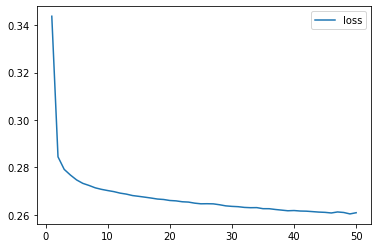

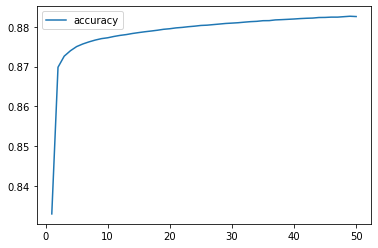

In [16]:
# Create a DataFrame with the history dictionary
df = pd.DataFrame(history.history, index=range(1, len(history.history["loss"]) + 1))

# Plot the loss
df.plot(y="loss")

# Plot the accuracy
df.plot(y="accuracy")

In [17]:
nn.save('shallow_nn.h5')